<a href="https://colab.research.google.com/github/yuhui-0611/contest/blob/main/Poverty_Prediction_Challenge_model_ver1_plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 회귀

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X = pd.read_csv('/content/drive/MyDrive/contest/train_hh_features.csv')
y1 = pd.read_csv('/content/drive/MyDrive/contest/train_hh_gt.csv')
y2 = pd.read_csv('/content/drive/MyDrive/contest/train_rates_gt.csv')

In [4]:
X_tr = pd.read_csv("/content/drive/MyDrive/contest/X_tr.csv")
X_val = pd.read_csv("/content/drive/MyDrive/contest/X_val.csv")
X_test = pd.read_csv("/content/drive/MyDrive/contest/X_test.csv")
y_tr = pd.read_csv("/content/drive/MyDrive/contest/y_tr.csv")
y_val = pd.read_csv("/content/drive/MyDrive/contest/y_val.csv")
test_id = pd.read_csv("/content/drive/MyDrive/contest/test_id.csv")
train = pd.read_csv("/content/drive/MyDrive/contest/train (3).csv")

In [5]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=0.2, random_state=42)
tr_idx, val_idx = next(gss.split(train, groups=train["survey_id"]))

train_df = train.iloc[tr_idx]
val_df   = train.iloc[val_idx]

**< 모델 입력에 필요한 최종 변수 >**

- X_tr
- X_val
- X_test
- y_tr
- y_val
- test_id

성능 = 가구-레벨 소비 예측과 빈곤율 예측 오류 기반

< 주요 평가 지표 >
- 가중 평균 오차(metric)

> 빈곤율 예측 오차 → 약 90% 비중

> 가구 소비 예측 오차 → 약 10% 비중

즉, 빈곤율 예측 정확도가 사실상 승부를 가른다고 보면 됨

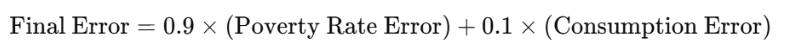

**< 범주형 분리 >**

In [6]:
cat_cols_tr = [c for c in X_tr.columns if X_tr[c].dtype == "object"]
cat_cols_val = [c for c in X_val.columns if X_val[c].dtype == "object"]
cat_cols_test = [c for c in X_test.columns if X_test[c].dtype == "object"]

In [7]:
cat_cols_tr

['male',
 'owner',
 'water',
 'toilet',
 'sewer',
 'elect',
 'water_source',
 'sanitation_source',
 'dweltyp',
 'employed',
 'educ_max',
 'any_nonagric',
 'sector1d',
 'urban']

In [8]:
X_tr['male']

,male
0,Female
1,Male
2,Female
3,Male
4,Male
...,...
72041,Female
72042,Female
72043,Male
72044,Male


# **< Consumption Error >**

# CatBoost

In [9]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [10]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [11]:
# 범주형 컬럼 인덱스
cat_features = [X_tr.columns.get_loc(c) for c in cat_cols_tr]

cb = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.02535,
    l2_leaf_reg=1.60403,
    depth=7,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=100,
    verbose=100
)

cb.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    cat_features=cat_features
)

0:	learn: 9.9690375	test: 9.7886156	best: 9.7886156 (0)	total: 300ms	remaining: 10m
100:	learn: 6.3603960	test: 6.3541287	best: 6.3541287 (100)	total: 22.6s	remaining: 7m 5s
200:	learn: 5.9951097	test: 6.0817451	best: 6.0817451 (200)	total: 38.1s	remaining: 5m 41s
300:	learn: 5.8231330	test: 5.9796503	best: 5.9796503 (300)	total: 52.2s	remaining: 4m 54s
400:	learn: 5.6992031	test: 5.9210098	best: 5.9210098 (400)	total: 1m 5s	remaining: 4m 23s
500:	learn: 5.5904880	test: 5.8753752	best: 5.8753752 (500)	total: 1m 20s	remaining: 3m 59s
600:	learn: 5.4901081	test: 5.8483222	best: 5.8483222 (600)	total: 1m 34s	remaining: 3m 39s
700:	learn: 5.4091623	test: 5.8276109	best: 5.8276109 (700)	total: 1m 48s	remaining: 3m 20s
800:	learn: 5.3437570	test: 5.8135255	best: 5.8135255 (800)	total: 2m 2s	remaining: 3m 3s
900:	learn: 5.2836267	test: 5.7989183	best: 5.7989183 (900)	total: 2m 15s	remaining: 2m 45s
1000:	learn: 5.2301196	test: 5.7897328	best: 5.7897328 (1000)	total: 2m 30s	remaining: 2m 30s
1

In [12]:
val_pred = cb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
rmse

np.float64(5.7413080719847)

# LightGBM

In [13]:
# !pip install lightgbm

In [14]:
import lightgbm as lgb

In [15]:
X_tr_lgb   = X_tr.copy()
X_val_lgb  = X_val.copy()
X_test_lgb = X_test.copy()

for c in cat_cols_tr:
    X_tr_lgb[c]   = X_tr_lgb[c].astype("category")
    X_val_lgb[c]  = X_val_lgb[c].astype("category")
    X_test_lgb[c] = X_test_lgb[c].astype("category")

In [16]:
lgb_model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=60,
    max_depth=7,
    min_child_samples=33,
    subsample=0.84020412,
    colsample_bytree=0.828,
    random_state=42
)

lgb_model.fit(
    X_tr_lgb, y_tr,
    eval_set=[(X_val_lgb, y_val)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(100)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 72046, number of used features: 85
[LightGBM] [Info] Start training from score 11.674833
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

LGBMRegressor(colsample_bytree=0.828, learning_rate=0.03, max_depth=7,
              min_child_samples=33, n_estimators=3000, num_leaves=60,
              objective='regression', random_state=42, subsample=0.84020412)

In [17]:
val_pred_lgb = lgb_model.predict(X_val_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_val, val_pred_lgb))
rmse_lgb

np.float64(5.768485619639357)

# XGBoost

In [18]:
from xgboost import XGBRegressor

In [19]:
X_tr_xgb   = X_tr.copy()
X_val_xgb  = X_val.copy()
X_test_xgb = X_test.copy()

In [20]:
cat_cols = X_tr_xgb.select_dtypes(include=["object"]).columns

for df in [X_tr_xgb, X_val_xgb, X_test_xgb]:
    df[cat_cols] = df[cat_cols].astype("category")

In [21]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=8000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_alpha=0.0,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist",
    eval_metric="rmse",
    enable_categorical=True,
)

xgb_model.fit(
    X_tr_xgb, y_tr,
    eval_set=[(X_val_xgb, y_val)],
    verbose=50,
)

[0]	validation_0-rmse:9.78430
[50]	validation_0-rmse:6.60424
[100]	validation_0-rmse:6.08422
[150]	validation_0-rmse:5.93185
[200]	validation_0-rmse:5.86913
[250]	validation_0-rmse:5.83907
[300]	validation_0-rmse:5.81798
[350]	validation_0-rmse:5.80661
[400]	validation_0-rmse:5.79947
[450]	validation_0-rmse:5.79406
[500]	validation_0-rmse:5.78654
[550]	validation_0-rmse:5.78063
[600]	validation_0-rmse:5.77723
[650]	validation_0-rmse:5.77654
[700]	validation_0-rmse:5.77514
[750]	validation_0-rmse:5.77733
[800]	validation_0-rmse:5.77659
[850]	validation_0-rmse:5.77412
[900]	validation_0-rmse:5.77501
[950]	validation_0-rmse:5.77430
[1000]	validation_0-rmse:5.77620
[1050]	validation_0-rmse:5.78031
[1100]	validation_0-rmse:5.77811
[1150]	validation_0-rmse:5.77926
[1200]	validation_0-rmse:5.77981
[1250]	validation_0-rmse:5.78238
[1300]	validation_0-rmse:5.78379
[1350]	validation_0-rmse:5.78585
[1400]	validation_0-rmse:5.78587
[1450]	validation_0-rmse:5.78800
[1500]	validation_0-rmse:5.78862


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=8000,
             n_jobs=None, num_parallel_tree=None, ...)

In [22]:
val_pred_xgb = xgb_model.predict(X_val_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_val, val_pred_xgb))
rmse_xgb

np.float64(5.909943571127902)

- rmse = 5.90994

# **< Poverty Rate Error >**

# **1. LightGBM**

In [23]:
val_sid = val_df["survey_id"].astype(str).to_numpy()   # survey_id
val_true = np.asarray(y_val).reshape(-1)   # 실제 소비값
val_pred_lgb = val_pred_lgb.astype(np.float32)   # 예측 소비값
val_true = val_true.astype(np.float32)   # 실제 소비값

threshold 값(3.17, 3.94, …) 이 컬럼 이름 안에 존재

In [24]:
# y2에서 poverty rate 정답 컬럼만 선택
rate_cols = [c for c in y2.columns if c.startswith("pct_hh_below_")]

# 컬럼 이름에서 threshold 값만 추출 -> 오름차순 정렬
threshold = {c: float(c.split("pct_hh_below_")[1]) for c in rate_cols}
rate_cols_sorted = sorted(rate_cols, key=lambda c: threshold[c])

thresholds = np.array([threshold[c] for c in rate_cols_sorted], dtype=np.float32)

In [25]:
y2_map = {}

# y2를 survey 단위로 한 줄씩 읽음
for _, row in y2[["survey_id"] + rate_cols_sorted].iterrows():
    sid = str(int(row["survey_id"])) if str(row["survey_id"]).endswith(".0") else str(row["survey_id"])   # 해당 survey의 ID
    y2_map[sid] = row[rate_cols_sorted].to_numpy(dtype=np.float32)

In [26]:
y_tr_log  = np.log1p(y_tr)
y_val_log = np.log1p(y_val)

In [27]:
lgb_model_log = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=60,
    max_depth=7,
    min_child_samples=33,
    subsample=0.84020412,
    colsample_bytree=0.828,
    random_state=42
)

lgb_model_log.fit(
    X_tr_lgb, y_tr_log,
    eval_set=[(X_val_lgb, y_val_log)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(100)]
)

val_pred_lgb_log = lgb_model_log.predict(X_val_lgb)
val_pred_lgb2 = np.expm1(val_pred_lgb_log)
val_pred_lgb2 = np.maximum(val_pred_lgb2, 0)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 72046, number of used features: 85
[LightGBM] [Info] Start training from score 2.328690
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

In [28]:
rmse_lgb_log = np.sqrt(mean_squared_error(y_val, val_pred_lgb2))
rmse_lgb_log

np.float64(5.810899775002462)

In [29]:
val_pred_lgb2 = np.asarray(val_pred_lgb2).astype(np.float32)
val_true_lgb2 = np.asarray(y_val).reshape(-1).astype(np.float32)

poverty_err_sum_lgb2 = 0.0
poverty_cnt_lgb2 = 0

for sid in np.unique(val_sid):
    gt_rates = y2_map.get(sid, None)
    if gt_rates is None:
        continue

    mask = (val_sid == sid)   # boolean
    pred_cons_lgb2 = val_pred_lgb2[mask]   # 예측 소비값

    # threshold별 예측 poverty rate = mean(cons_pred < threshold)
    # (n,1) < (k,) 하면 (n,k) bool 만들어짐
    # mean axis=0 하면 길이 k 벡터가 됨
    pr_pred_lgb2 = (pred_cons_lgb2[:, None] < thresholds[None, :]).mean(axis=0).astype(np.float32)
    ape_lgb2 = np.abs(pr_pred_lgb2 - gt_rates) / np.clip(gt_rates, 1e-6, None)

    poverty_err_sum_lgb2 += float(ape_lgb2.sum())
    poverty_cnt_lgb2 += ape_lgb2.size

poverty_error_lgb2 = poverty_err_sum_lgb2 / poverty_cnt_lgb2
print("Poverty Error (LGB):", poverty_error_lgb2)

Poverty Error (LGB): 0.05333997701343737


In [30]:
cons_error_lgb2 = float(np.mean(np.abs(val_pred_lgb2 - val_true_lgb2) / np.clip(val_true_lgb2, 1e-6, None)))
print("Consumption Error (LGB):", cons_error_lgb2)

Consumption Error (LGB): 0.28253546357154846


### Final Error

In [31]:
final_error_lgb2 = 0.9 * poverty_error_lgb2 + 0.1 * cons_error_lgb2
print("Final Error (LGB):", final_error_lgb2)

Final Error (LGB): 0.07625952566924848


- Final Error (LGB): 0.0762595

# **2. XGBoost**

In [32]:
xgb_model_log = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_alpha=0.0,
    reg_lambda=1.0,
    objective="reg:squarederror",
    tree_method="hist",
    eval_metric="rmse",
    enable_categorical=True,
    random_state=42,
)

xgb_model_log.fit(
    X_tr_xgb,
    y_tr_log,
    eval_set=[(X_val_xgb, y_val_log)],
    verbose=False,
)

val_pred_xgb_log = xgb_model_log.predict(X_val_xgb)
val_pred_xgb2 = np.expm1(val_pred_xgb_log)
val_pred_xgb2 = np.maximum(val_pred_xgb2, 0)

In [33]:
rmse_xgb_log = np.sqrt(mean_squared_error(y_val, val_pred_xgb2))
rmse_xgb_log

np.float64(5.815833007765848)

In [34]:
val_pred_xgb2 = np.asarray(val_pred_xgb2).astype(np.float32)
val_true_xgb2 = np.asarray(y_val).reshape(-1).astype(np.float32)

poverty_err_sum_xgb2 = 0.0
poverty_cnt_xgb2 = 0

for sid in np.unique(val_sid):
    gt_rates = y2_map.get(sid, None)
    if gt_rates is None:
        continue

    mask = (val_sid == sid)   # boolean
    pred_cons_xgb2 = val_pred_xgb2[mask]   # 예측 소비값

    # threshold별 예측 poverty rate = mean(cons_pred < threshold)
    # (n,1) < (k,) 하면 (n,k) bool 만들어짐
    # mean axis=0 하면 길이 k 벡터가 됨
    pr_pred_xgb2 = (pred_cons_xgb2[:, None] < thresholds[None, :]).mean(axis=0).astype(np.float32)
    ape_xgb2 = np.abs(pr_pred_xgb2 - gt_rates) / np.clip(gt_rates, 1e-6, None)

    poverty_err_sum_xgb2 += float(ape_xgb2.sum())
    poverty_cnt_xgb2 += ape_xgb2.size

poverty_error_xgb2 = poverty_err_sum_xgb2 / poverty_cnt_xgb2
print("Poverty Error (XGB):", poverty_error_xgb2)

Poverty Error (XGB): 0.05043391177528783


In [35]:
cons_error_xgb2 = float(np.mean(np.abs(val_pred_xgb2 - val_true_xgb2) / np.clip(val_true_xgb2, 1e-6, None)))
print("Consumption Error (XGB):", cons_error_xgb2)

Consumption Error (XGB): 0.28388386964797974


In [36]:
final_error_xgb2 = 0.9 * poverty_error_xgb2 + 0.1 * cons_error_xgb2
print("Final Error (XGB):", final_error_xgb2)

Final Error (XGB): 0.07377890756255702


- Final Error (XGB): 0.0737789

# **3. CatBoost**

In [37]:
cb_model_log = CatBoostRegressor(
    loss_function="RMSE",
    iterations=3000,
    learning_rate=0.03,
    depth=6,
    subsample=0.8,
    random_seed=42,
    eval_metric="RMSE",
    verbose=100
)

cb_model_log.fit(
    X_tr, y_tr_log,
    eval_set=(X_val, y_val_log),
    cat_features=cat_features,
    use_best_model=True,
    early_stopping_rounds=100
)

val_pred_log = cb_model_log.predict(X_val)
val_pred2 = np.expm1(val_pred_log)
val_pred2 = np.maximum(val_pred2, 0)

0:	learn: 0.6126454	test: 0.6171482	best: 0.6171482 (0)	total: 231ms	remaining: 11m 33s
100:	learn: 0.3430133	test: 0.3505752	best: 0.3505752 (100)	total: 11.6s	remaining: 5m 31s
200:	learn: 0.3210849	test: 0.3292075	best: 0.3292075 (200)	total: 23.3s	remaining: 5m 25s
300:	learn: 0.3133654	test: 0.3218239	best: 0.3218239 (300)	total: 36.6s	remaining: 5m 27s
400:	learn: 0.3085339	test: 0.3175168	best: 0.3175168 (400)	total: 48.4s	remaining: 5m 13s
500:	learn: 0.3049653	test: 0.3149185	best: 0.3149185 (500)	total: 59.9s	remaining: 4m 58s
600:	learn: 0.3023449	test: 0.3130885	best: 0.3130885 (600)	total: 1m 9s	remaining: 4m 39s
700:	learn: 0.3001704	test: 0.3117794	best: 0.3117794 (700)	total: 1m 21s	remaining: 4m 26s
800:	learn: 0.2984902	test: 0.3109187	best: 0.3109187 (800)	total: 1m 32s	remaining: 4m 13s
900:	learn: 0.2970313	test: 0.3103098	best: 0.3103098 (900)	total: 1m 43s	remaining: 4m
1000:	learn: 0.2957173	test: 0.3097606	best: 0.3097606 (1000)	total: 1m 52s	remaining: 3m 43s


In [38]:
rmse_log = np.sqrt(mean_squared_error(y_val, val_pred2))
rmse_log

np.float64(5.797140326543541)

In [39]:
val_pred2 = np.asarray(val_pred2).astype(np.float32)
val_true2 = np.asarray(y_val).reshape(-1).astype(np.float32)

poverty_err_sum2 = 0.0
poverty_cnt2 = 0

for sid in np.unique(val_sid):
    gt_rates = y2_map.get(sid, None)
    if gt_rates is None:
        continue

    mask = (val_sid == sid)   # boolean
    pred_cons2 = val_pred2[mask]   # 예측 소비값

    # threshold별 예측 poverty rate = mean(cons_pred < threshold)
    # (n,1) < (k,) 하면 (n,k) bool 만들어짐
    # mean axis=0 하면 길이 k 벡터가 됨
    pr_pred2 = (pred_cons2[:, None] < thresholds[None, :]).mean(axis=0).astype(np.float32)
    ape2 = np.abs(pr_pred2 - gt_rates) / np.clip(gt_rates, 1e-6, None)

    poverty_err_sum2 += float(ape2.sum())
    poverty_cnt2 += ape2.size

poverty_error2 = poverty_err_sum2 / poverty_cnt2
print("Poverty Error (CB):", poverty_error2)

Poverty Error (CB): 0.05434743981612356


In [40]:
cons_error2 = float(np.mean(np.abs(val_pred2 - val_true2) / np.clip(val_true2, 1e-6, None)))
print("Consumption Error (CB):", cons_error2)

Consumption Error (CB): 0.28112879395484924


### Final Error

In [41]:
final_error2 = 0.9 * poverty_error2 + 0.1 * cons_error2
print("Final Error (CB):", final_error2)

Final Error (CB): 0.07702557522999613


- Final Error (CB): 0.077026

# 앙상블

In [42]:
def calc_errors(pred):
    """
    pred: 검증셋 소비 예측 (원래 스케일, 1차원)
    return: (poverty_error, cons_error, final_error)
    """
    pred = np.asarray(pred, dtype=np.float32)
    true = val_true.astype(np.float32)

    # 1) poverty error
    poverty_err_sum = 0.0
    poverty_cnt = 0

    for sid in np.unique(val_sid):
        gt_rates = y2_map.get(sid, None)
        if gt_rates is None:
            continue

        mask = (val_sid == sid)
        cons = pred[mask]  # 이 survey_id의 예측 소비값들

        # threshold별 예측 poverty rate
        # cons: (n,), thresholds: (k,) -> (k,)
        pr_pred = (cons[:, None] < thresholds[None, :]).mean(axis=0).astype(np.float32)

        # GT와의 MAPE
        ape = np.abs(pr_pred - gt_rates) / np.clip(gt_rates, 1e-6, None)

        poverty_err_sum += float(ape.sum())
        poverty_cnt     += ape.size

    poverty_error = poverty_err_sum / poverty_cnt

    # 2) consumption error
    cons_error = float(
        np.mean(
            np.abs(pred - true) / np.clip(true, 1e-6, None)
        )
    )

    # 3) final error
    final_error = 0.9 * poverty_error + 0.1 * cons_error

    return poverty_error, cons_error, final_error

## LGB + XGB / XGB + CB / LGB + CB

In [43]:
pairs = {
    "LGB+XGB": (val_pred_lgb2, val_pred_xgb2),
    "LGB+CB" : (val_pred_lgb2, val_pred),
    "XGB+CB" : (val_pred_xgb2, val_pred),
}

alphas = np.linspace(0.0, 1.0, 21)  # 0.0 ~ 1.0, step 0.05

best_pair_results = {}

for name, (p1, p2) in pairs.items():
    best_fe = 1e9
    best_a  = None
    best_pe = None
    best_ce = None

    for a in alphas:
        pred_mix = a * p1 + (1.0 - a) * p2
        pe, ce, fe = calc_errors(pred_mix)
        if fe < best_fe:
            best_fe = fe
            best_a, best_pe, best_ce = a, pe, ce

    best_pair_results[name] = (best_a, best_pe, best_ce, best_fe)

print("=== Best 2-model ensembles ===")
for name, (a, pe, ce, fe) in best_pair_results.items():
    print(f"{name}: alpha={a:4.2f} | poverty={pe:.6f} | cons={ce:.6f} | final={fe:.6f}")

=== Best 2-model ensembles ===
LGB+XGB: alpha=0.05 | poverty=0.050389 | cons=0.283592 | final=0.073709
LGB+CB: alpha=0.90 | poverty=0.052587 | cons=0.284166 | final=0.075745
XGB+CB: alpha=0.90 | poverty=0.049745 | cons=0.285089 | final=0.073279


- final = 0.073279

### Submission

In [44]:
# 1. 각 모델의 log 스케일 예측
test_pred_lgb_log = lgb_model_log.predict(X_test_lgb)
test_pred_xgb_log = xgb_model_log.predict(X_test_xgb)
test_pred_cb_log  = cb_model_log.predict(X_test)

# 2. log1p → 원래 스케일로 복원 + 음수 방지
def back_transform(y_log):
    # y_log는 log1p(y)이므로 expm1으로 되돌림
    y = np.expm1(y_log)
    return np.maximum(y, 0.0)

test_pred_lgb2 = back_transform(test_pred_lgb_log)
test_pred_xgb2 = back_transform(test_pred_xgb_log)
test_pred_cb2  = back_transform(test_pred_cb_log)

In [45]:
target_pair = "XGB+CB"

pair_test_preds = {
    "LGB+XGB": (test_pred_lgb2, test_pred_xgb2),
    "LGB+CB" : (test_pred_lgb2, test_pred_cb2),
    "XGB+CB" : (test_pred_xgb2, test_pred_cb2),
}

# validation에서 미리 계산해 둔 best_pair_results에서 alpha 꺼내오기
best_a, best_pe, best_ce, best_fe = best_pair_results[target_pair]

print(
    f"[{target_pair}] best alpha={best_a:0.2f}, "
    f"val final_error={best_fe:.6f}"
)

# 선택한 pair의 test 예측 두 개 가져오기
p1_test, p2_test = pair_test_preds[target_pair]

test_pred_mix = best_a * p1_test + (1.0 - best_a) * p2_test

[XGB+CB] best alpha=0.90, val final_error=0.073279


In [46]:
test_sid  = test_id["survey_id"].to_numpy()
test_hhid = test_id["hhid"].to_numpy()

submission_cons = pd.DataFrame({
    "survey_id": test_sid,
    "hhid":      test_hhid,
    "cons_ppp17": test_pred_mix,
})

submission_cons.to_csv("predicted_household_consumption.csv", index=False)

with open("predicted_household_consumption.csv", "r") as f:
    for _ in range(3):
        print(f.readline().strip())

survey_id,hhid,cons_ppp17
400000,400001,10.910041924139453
400000,400002,7.372263292108211


In [47]:
pov_rows = []

for sid in np.unique(test_sid):
    mask = (test_sid == sid)
    cons = test_pred_mix[mask]

    # 각 threshold에 대해 비율 계산
    rates = (cons[:, None] < thresholds[None, :]).mean(axis=0)

    row = {"survey_id": sid}
    for c, r in zip(rate_cols_sorted, rates):
        row[c] = float(r)
    pov_rows.append(row)

submission_pov = pd.DataFrame(
    pov_rows,
    columns=["survey_id"] + rate_cols_sorted
)

submission_pov.to_csv("predicted_poverty_distribution.csv", index=False)

with open("predicted_poverty_distribution.csv", "r") as f:
    for _ in range(2):
        print(f.readline().strip())

survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
400000,0.019904527701432084,0.06017647909735281,0.11398813829017793,0.17430927238536092,0.23303920150441199,0.2864458267033126,0.33484738897728916,0.387588601186171,0.44027195139592074,0.4918269926225951,0.5399681759004774,0.587617532185737,0.6352090264718646,0.6870244466946333,0.7407493128887603,0.79343266309851,0.8455373933169391,0.8979603645305946,0.9534500216982497


# RF 보조판단 후처리



```
(1) LGBM / XGB / CB 회귀 예측 (소비액)
(2) threshold 하나 선택
    - 각 임계값에서 빈곤 비율이 어느 정도인지 확인
    - 0.2~0.5 사이쯤 되는 것으로 선택
(3) 임계값 ± margin → shaky zone
(4) RF 빈곤 확률로 라벨 뒤집기
(5) household → survey 단위 집계
(6) y2_map과 비교해 wMAPE 계산
```



In [48]:
# cons_ppp17: train 쪽 실제 소비액 컬럼
cons = y_tr['cons_ppp17'].to_numpy()

poor_rates = []
for t in thresholds:
    poor_rate = (cons < t).mean()   # 해당 threshold 기준으로 빈곤 비율
    poor_rates.append(poor_rate)

poor_rates = np.array(poor_rates)

# 0.2~0.5 범위 안에 있는 threshold 중에서, 가장 가운데에 가까운 값 선택
mask = (poor_rates >= 0.2) & (poor_rates <= 0.5)

if mask.any():
    # 그 중에서도 median에 가장 가까운 것
    candidate_idx = np.where(mask)[0]
    mid_idx = candidate_idx[len(candidate_idx) // 2]
else:
    # 그런 게 없으면 그냥 전체 중간값 사용
    mid_idx = len(thresholds) // 2

REPRESENTATIVE_THRESHOLD = thresholds[mid_idx]
print("선택된 대표 임계값:", REPRESENTATIVE_THRESHOLD,
      "→ 해당 기준 빈곤 비율:", poor_rates[mid_idx])

선택된 대표 임계값: 7.06 → 해당 기준 빈곤 비율: 0.3752186103322877


In [49]:
# 보정 파라미터 (슬라이드에서 쓰던 값 그대로)
MARGIN_RATIO = 0.1   # 임계값 ±10% 구간을 '애매한 구간'으로
PROBA_HIGH  = 0.7    # RF 확률이 70% 이상이면 빈곤으로 보정
PROBA_LOW   = 0.3    # RF 확률이 30% 이하면 비빈곤으로 보정

## **1. rf 분류기 학습**

In [50]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

In [51]:
y_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72046 entries, 0 to 72045
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cons_ppp17  72046 non-null  float64
dtypes: float64(1)
memory usage: 563.0 KB


In [52]:
# 1) RF 타깃: 대표 임계값 기준 빈곤(1)/비빈곤(0)
y_train_clf = (y_tr['cons_ppp17'] < REPRESENTATIVE_THRESHOLD).astype(int)

In [53]:
# 2) RF에 쓸 feature
X_train_rf = X_tr.copy()
X_val_rf   = X_val.copy()
X_test_rf  = X_test.copy()

# 범주형 컬럼 인코딩 (object / category → 숫자)
cat_cols_rf = X_train_rf.select_dtypes(include=["object", "category"]).columns

enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
if len(cat_cols_rf) > 0:
    X_train_rf[cat_cols_rf] = enc.fit_transform(X_train_rf[cat_cols_rf])
    X_val_rf[cat_cols_rf]   = enc.transform(X_val_rf[cat_cols_rf])
    X_test_rf[cat_cols_rf]  = enc.transform(X_test_rf[cat_cols_rf])

# 3) RF 분류기 학습
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',   # 빈곤/비빈곤 불균형 보정
)

rf_clf.fit(X_train_rf, y_train_clf)

# 4) validation/test에 대한 RF 빈곤 확률 (클래스1=빈곤)
rf_proba_val  = rf_clf.predict_proba(X_val_rf)[:, 1]
rf_proba_test = rf_clf.predict_proba(X_test_rf)[:, 1]

## **2. RF 보조판단 함수**

In [54]:
def apply_rf_correction(
    y_pred_cons,      # 회귀모델의 소비액 예측 (원 스케일)
    rf_proba,         # RF가 예측한 빈곤 확률
    threshold,        # REPRESENTATIVE_THRESHOLD (7.06)
    margin_ratio=0.1,
    proba_low=0.3,
    proba_high=0.7,
):
    """
    회귀 예측 + RF 확률을 이용해 최종 빈곤/비빈곤(0/1) 라벨을 리턴
    """
    y_pred_cons = np.asarray(y_pred_cons, dtype=np.float32)
    rf_proba    = np.asarray(rf_proba,    dtype=np.float32)

    # 1차 판정: 회귀 예측이 threshold보다 작으면 빈곤(1)
    base_label = (y_pred_cons < threshold).astype(np.int8)

    # 임계값 ± margin 구간을 '애매한 구간'으로 정의
    lower = threshold * (1.0 - margin_ratio)
    upper = threshold * (1.0 + margin_ratio)
    is_shaky = (y_pred_cons >= lower) & (y_pred_cons <= upper)

    final_label = base_label.copy()

    # 상향 보정: 회귀는 비빈곤(0)이라 했지만,
    #           애매한 구간 + RF 확률이 높으면(>= proba_high) → 빈곤(1)
    cond_up = (base_label == 0) & is_shaky & (rf_proba >= proba_high)
    final_label[cond_up] = 1

    # 하향 보정: 회귀는 빈곤(1)이라 했지만,
    #           애매한 구간 + RF 확률이 낮으면(<= proba_low) → 비빈곤(0)
    cond_down = (base_label == 1) & is_shaky & (rf_proba <= proba_low)
    final_label[cond_down] = 0

    return final_label, base_label, is_shaky

## **3. 각 모델별로 RF 보정 라벨 생성**

In [55]:
# LGBM
poor_final_lgb,  base_lgb,  shaky_lgb  = apply_rf_correction(
    val_pred_lgb2,
    rf_proba_val,
    REPRESENTATIVE_THRESHOLD,
    margin_ratio=MARGIN_RATIO,
    proba_low=PROBA_LOW,
    proba_high=PROBA_HIGH,
)

# XGB
poor_final_xgb, base_xgb, shaky_xgb = apply_rf_correction(
    val_pred_xgb2,
    rf_proba_val,
    REPRESENTATIVE_THRESHOLD,
    margin_ratio=MARGIN_RATIO,
    proba_low=PROBA_LOW,
    proba_high=PROBA_HIGH,
)

# CatBoost
poor_final_cb,  base_cb,  shaky_cb  = apply_rf_correction(
    val_pred2,
    rf_proba_val,
    REPRESENTATIVE_THRESHOLD,
    margin_ratio=MARGIN_RATIO,
    proba_low=PROBA_LOW,
    proba_high=PROBA_HIGH,
)

## **4. poverty / final error 재계산 (RF 버전)**

In [56]:
# 대표 임계값이 thresholds에서 몇 번째인지
rep_idx = mid_idx

### LGBM + RF 보정

In [57]:
# ---------- LGBM RF 보정 버전 ----------
poverty_err_sum_lgb2_rf = 0.0
poverty_cnt_lgb2_rf     = 0

for sid in np.unique(val_sid):
    gt_rates = y2_map.get(sid, None)
    if gt_rates is None:
        continue

    mask = (val_sid == sid)
    pred_cons_lgb2_sid = val_pred_lgb2[mask]
    poor_final_sid     = poor_final_lgb[mask]   # RF 보정된 0/1 라벨

    # (household, threshold) 형태의 bool 행렬
    poor_bool = (pred_cons_lgb2_sid[:, None] < thresholds[None, :])

    # 대표 임계값 열(rep_idx)은 RF 라벨로 덮어쓰기
    poor_bool[:, rep_idx] = poor_final_sid.astype(bool)

    # threshold별 poverty rate
    pr_pred_lgb2_rf = poor_bool.mean(axis=0).astype(np.float32)

    # APE 계산
    ape_lgb2_rf = np.abs(pr_pred_lgb2_rf - gt_rates) / np.clip(gt_rates, 1e-6, None)

    poverty_err_sum_lgb2_rf += float(ape_lgb2_rf.sum())
    poverty_cnt_lgb2_rf     += ape_lgb2_rf.size

poverty_error_lgb2_rf = poverty_err_sum_lgb2_rf / poverty_cnt_lgb2_rf
print("Poverty Error (LGBM + RF):", poverty_error_lgb2_rf)

# consumption error는 그대로 사용 (소비액 자체는 안 바뀜)
cons_error_lgb2_rf = cons_error_lgb2
print("Consumption Error (LGBM + RF):", cons_error_lgb2_rf)

final_error_lgb2_rf = 0.9 * poverty_error_lgb2_rf + 0.1 * cons_error_lgb2_rf
print("Final Error (LGBM + RF):", final_error_lgb2_rf)

Poverty Error (LGBM + RF): 0.054272858720076714
Consumption Error (LGBM + RF): 0.28253546357154846
Final Error (LGBM + RF): 0.07709911920522389


### XGB + RF 보정

In [58]:
# ---------- XGB RF 보정 버전 ----------
poverty_err_sum_xgb2_rf = 0.0
poverty_cnt_xgb2_rf     = 0

for sid in np.unique(val_sid):
    gt_rates = y2_map.get(sid, None)
    if gt_rates is None:
        continue

    mask = (val_sid == sid)
    pred_cons_xgb2_sid = val_pred_xgb2[mask]
    poor_final_sid     = poor_final_xgb[mask]

    poor_bool = (pred_cons_xgb2_sid[:, None] < thresholds[None, :])
    poor_bool[:, rep_idx] = poor_final_sid.astype(bool)

    pr_pred_xgb2_rf = poor_bool.mean(axis=0).astype(np.float32)
    ape_xgb2_rf = np.abs(pr_pred_xgb2_rf - gt_rates) / np.clip(gt_rates, 1e-6, None)

    poverty_err_sum_xgb2_rf += float(ape_xgb2_rf.sum())
    poverty_cnt_xgb2_rf     += ape_xgb2_rf.size

poverty_error_xgb2_rf = poverty_err_sum_xgb2_rf / poverty_cnt_xgb2_rf
print("Poverty Error (XGB + RF):", poverty_error_xgb2_rf)

cons_error_xgb2_rf = cons_error_xgb2
print("Consumption Error (XGB + RF):", cons_error_xgb2_rf)

final_error_xgb2_rf = 0.9 * poverty_error_xgb2_rf + 0.1 * cons_error_xgb2_rf
print("Final Error (XGB + RF):", final_error_xgb2_rf)

Poverty Error (XGB + RF): 0.05139804200122231
Consumption Error (XGB + RF): 0.28388386964797974
Final Error (XGB + RF): 0.07464662476589806


### CatBoost + RF 보정

In [59]:
# ---------- CatBoost RF 보정 버전 ----------
poverty_err_sum_cb_rf = 0.0
poverty_cnt_cb_rf     = 0

for sid in np.unique(val_sid):
    gt_rates = y2_map.get(sid, None)
    if gt_rates is None:
        continue

    mask = (val_sid == sid)
    pred_cons_cb_sid = val_pred2[mask]
    poor_final_sid   = poor_final_cb[mask]

    poor_bool = (pred_cons_cb_sid[:, None] < thresholds[None, :])
    poor_bool[:, rep_idx] = poor_final_sid.astype(bool)

    pr_pred_cb_rf = poor_bool.mean(axis=0).astype(np.float32)
    ape_cb_rf = np.abs(pr_pred_cb_rf - gt_rates) / np.clip(gt_rates, 1e-6, None)

    poverty_err_sum_cb_rf += float(ape_cb_rf.sum())
    poverty_cnt_cb_rf     += ape_cb_rf.size

poverty_error_cb_rf = poverty_err_sum_cb_rf / poverty_cnt_cb_rf
print("Poverty Error (CB + RF):", poverty_error_cb_rf)

cons_error_cb_rf = cons_error2
print("Consumption Error (CB + RF):", cons_error_cb_rf)

final_error_cb_rf = 0.9 * poverty_error_cb_rf + 0.1 * cons_error_cb_rf
print("Final Error (CB + RF):", final_error_cb_rf)

Poverty Error (CB + RF): 0.05513302276009008
Consumption Error (CB + RF): 0.28112879395484924
Final Error (CB + RF): 0.077732599879566


In [60]:
flip_rate = np.mean(base_lgb != poor_final_lgb)
print("LGB 뒤집힌 비율:", flip_rate)

print("shaky 비율:", shaky_lgb.mean())


LGB 뒤집힌 비율: 0.007735802162296508
shaky 비율: 0.11637877469864545


In [61]:
diff = np.abs(val_pred_lgb2 - REPRESENTATIVE_THRESHOLD)
print("뒤집힌 샘플 평균 거리:",
      diff[base_lgb != poor_final_lgb].mean())


뒤집힌 샘플 평균 거리: 0.29626647
